In [1]:
# Pipeline
import sagemaker
import boto3

In [2]:
# get Model
# best metrics 101 deeplab 0001 0931
#ss_estimator = sagemaker.estimator.Estimator.attach("SemSeg-resnet101-deeplab-lr0001-2022-06-27-19-46")

#101-deeplab-001 
#ss_estimator = sagemaker.estimator.Estimator.attach("SemSeggler-deeplab-resnet101-2022-06-24-13-26")


# 101-psp-0001 0898
#ss_estimator = sagemaker.estimator.Estimator.attach("SemSeg-resnet101-fcn-lr001-2022-06-27-19-05")

# 101-psp-001 0898
#ss_estimator = sagemaker.estimator.Estimator.attach("SemSeggler-psp-resnet101-2022-06-24-14-26")


# 101-fcn-001 082
ss_estimator = sagemaker.estimator.Estimator.attach("SemSeg-resnet101-fcn-lr001-2022-06-27-18-37")

# 50-deeplab-0001 
#ss_estimator = sagemaker.estimator.Estimator.attach("SemSeg-resnet50-deeplab-lr0001-2-2022-06-27-18-08")

# 50-deeplab-001 
#ss_estimator = sagemaker.estimator.Estimator.attach("SemSeg-resnet50-deeplab-lr001-2022-06-27-16-46")


# 50-fcn-0001 0533
#ss_estimator = sagemaker.estimator.Estimator.attach("SemSeg-resnet50-deeplab-lr0001-2022-06-27-12-47")
#SemSeg-resnet50-psp-lr0001-2022-06-27-11-19

# 50-fcn-001 0533
#ss_estimator = sagemaker.estimator.Estimator.attach("SemSeg-resnet50-fcn-lr001-2022-06-26-14-33")


# 50-psp-0001 
#ss_estimator = sagemaker.estimator.Estimator.attach("SemSeg-resnet50-psp-lr0001-2022-06-27-09-32")

# 50-psp-001 086
ss_estimator = sagemaker.estimator.Estimator.attach("SemSeg-resnet50-psp-lr1-2022-06-27-08-47")

# 50 fcn 01 0533
#ss_estimator = sagemaker.estimator.Estimator.attach("SemSeg-resnet50-fcn-lr01-2022-06-26-15-11")

# worst metrics 50 deeplab 01 0472
#ss_estimator = sagemaker.estimator.Estimator.attach("SemSeg-resnet50-deeplab-lr01-2022-06-27-14-12")




2022-06-27 19:01:55 Starting - Preparing the instances for training
2022-06-27 19:01:55 Downloading - Downloading input data
2022-06-27 19:01:55 Training - Training image download completed. Training in progress.
2022-06-27 19:01:55 Uploading - Uploading generated training model
2022-06-27 19:01:55 Completed - Training job completed

2022-06-27 09:12:53 Starting - Preparing the instances for training
2022-06-27 09:12:53 Downloading - Downloading input data
2022-06-27 09:12:53 Training - Training image download completed. Training in progress.
2022-06-27 09:12:53 Uploading - Uploading generated training model
2022-06-27 09:12:53 Completed - Training job completed


In [3]:
# Deploy Model to endpoint
ss_predictor = ss_estimator.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")

----

KeyboardInterrupt: 

In [ ]:
from sagemaker.predictor import Predictor

ss_predictor = Predictor(endpoint_name="SemSeg-resnet50-psp-lr1-2022-06-27-08-4-2022-07-31-18-45-14-459")

In [593]:
# predict
prefix_image = "image/"
prefix_mask = "masks/"
#filename_raw = "fzfs_1.png"
#filename_raw = "fzfs_3.png"
#filename_raw = "5.jpg"
filename_raw = "IMG_8335.png"
#filename_raw = "hr_bw_cont.png"
#filename_raw = "hr_bw.jpg"
#filename_raw = "thumbnail_image001.png"

#groundtruth = "IMG_8335_Mask.png"

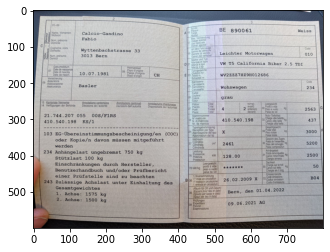

In [594]:
from matplotlib import pyplot as plt
import PIL

%matplotlib inline

filename = f"Original_{filename_raw}-resized.png"
width = 800

im = PIL.Image.open(prefix_image + filename_raw)
#im_gt = PIL.Image.open(prefix_mask + groundtruth)

aspect = im.size[0] / im.size[1]
#aspect_gt = im_gt.size[0] / im_gt.size[1]

im.thumbnail([width, int(width / aspect)], PIL.Image.ANTIALIAS)
im.save(f'resized_image/50-psp-001-{filename}', "PNG")

#im_gt.thumbnail([width, int(width / aspect_gt)], PIL.Image.ANTIALIAS)
#im_gt.save(f'resized_image/Mask-resized-{filename}', "PNG")

plt.imshow(im)
plt.show()
#plt.imshow(im_gt)
#plt.show() 

In [595]:
from PIL import Image
import numpy as np


class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


ss_predictor.deserializer = ImageDeserializer(accept="image/png")


In [596]:
ss_predictor.serializer = sagemaker.serializers.IdentitySerializer("image/png")

with open(f'resized_image/50-psp-001-{filename}', "rb") as imfile:
    imbytes = imfile.read()

In [597]:
%%time

cls_mask = ss_predictor.predict(imbytes)
print(type(cls_mask))
print(cls_mask.shape)

<class 'numpy.ndarray'>
(600, 800)
CPU times: user 10.1 ms, sys: 3 µs, total: 10.1 ms
Wall time: 7.08 s


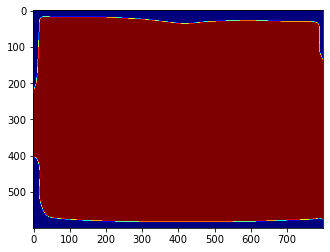

In [598]:
plt.imshow(cls_mask, cmap="jet")
plt.imsave(f'predictions/50-psp-001-{filename_raw}', cls_mask)
plt.show()

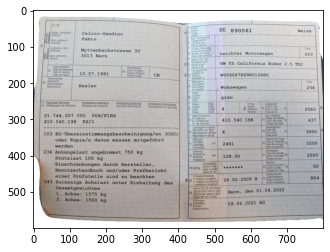

In [599]:
from PIL import Image
import cv2
import numpy

image_res = numpy.array(Image.open(f'resized_image/50-psp-001-{filename}'))
boolean_mask = cls_mask[:,:]==0
image_res[boolean_mask] = [255,255,255]
plt.imsave(f'extracted_images/50-psp-001-{filename_raw}-extracted.png', image_res)
plt.imshow(image_res)

NameError: name 'im_gt' is not defined

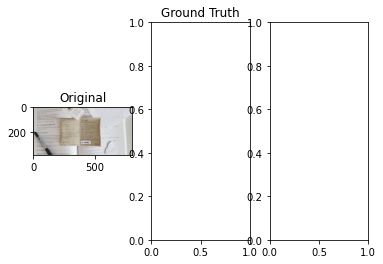

In [28]:
f, axarr = plt.subplots(1,3)
axarr[0].set_title('Original')
axarr[0].imshow(im)
axarr[1].set_title('Ground Truth')
axarr[1].imshow(im_gt)
axarr[2].set_title('Prediction')
axarr[2].imshow(cls_mask)
f.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.8,
                    hspace=0.8)

In [600]:
# Delete Endpoint
ss_predictor.delete_endpoint()